In [105]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import sys, os
from utils.basic_utils import *
from utils.pricing import *
from utils.fundamental import *
from utils import ml_utils as mu

pd.options.display.float_format = '{:,.2f}'.format

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import forest

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, log_loss, precision_recall_fscore_support
from sklearn.metrics import precision_score, roc_auc_score

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.externals import joblib

import numpy as np
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, Adagrad, Adadelta, Adamax, Nadam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import CSVLogger

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [3]:
# environment variables
freq = '1d'
cuts = { '1d': [-1, -0.1, -.02, .02, .1, 1.] }
cut_range = cuts[freq]
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]

# pricing, refresh once
benchSL, sectorSL, riskSL, rateSL, bondSL, commSL, currSL = \
    config['benchmarks'], config['sectors'], config['risk'], config['rates'], \
    config['bonds'], config['commodities'], config['currencies']
symbols_list = benchSL + sectorSL + riskSL + rateSL + bondSL + commSL + currSL

keep_bench = excl(benchSL, ['^STOXX50E', '^AXJO'])
keep_fx = excl(currSL, ['HKD=X', 'MXN=X', 'AUDUSD=X', 'NZDUSD=X', 'TWD=X', 'CLP=X', 'KRW=X'])
keep_sect = excl(sectorSL, ['SPY', 'QQQ', 'DIA', 'IWM', 'XLC', 'XLRE'])
keep_bonds = ['LQD', 'HYG']

include = riskSL + keep_bench + keep_sect + rateSL + keep_fx + keep_bonds
invert = ['EURUSD=X', 'GBPUSD=X']
incl_price = riskSL

bench = '^GSPC'
y_col = 'fwdReturn'
pred_fwd_windows = [20, 60, 120]
rate_windows = [20, 60]
sec_windows, stds = [5, 20, 60], 1

In [100]:
# utility functions
def create_ds(px_close, context):
    print('create_ds')
    portion = context['portion']
    verbose = context['verbose']
    # average the return of the next periods
    # select only rows where Y variable is not null
    ds_idx = px_close.dropna(subset=[bench]).index

    df_large = pd.DataFrame()
    rate_ft_df = rate_feats(px_close[rateSL], rate_windows) # rate transforms
    df_large[rate_ft_df.columns] = rate_ft_df

    # price momentum transforms
    super_list = []
    for ticker in include:
        inv = ticker in invert
        incl_px = ticker in incl_price
        df = px_close[ticker]
        ft_df = px_mom_feats(df, ticker, stds, inv, incl_px, sec_windows)
        super_list.append(ft_df.drop_duplicates())
    df_large = pd.concat(super_list, axis=1).sort_index()
    df_large = df_large.loc[ds_idx, :] # drop NAs before discretizing

    return ds_idx, df_large

def pre_process_ds(raw_df, context):
    
    print('pre_process_ds')
    fill_on, scaler_on = context['fill'], context['scale']
    ml_path = context['ml_path']
    train_cols = context['trained_cols']
    test_sz, verbose = context['test_size'], context['verbose']

    scaler = StandardScaler()
    X_cols = excl(raw_df.columns, [y_col])

    raw_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    if scaler_on: raw_df[X_cols] = scaler.fit_transform(raw_df[X_cols])
    if fill_on: raw_df.loc[:, X_cols] = raw_df.fillna(method=fill_on)

    return raw_df

def train_ds(context):
    
    print('Benchmark: {}, Y: {}, Include: {}, invert: {}, include price: {}'.format(
    bench, y_col, include, invert, incl_price))

    context['train_model'] = True
    ml_path = context['ml_path']
    verbose = context['verbose']
    units = context['units']
    max_iter = context['max_iter']
    l2_reg = context['l2_reg']
    dropout = context['dropout']
    trained_cols = context['trained_cols']
    imputer_on = context['impute']
    test_sz = context['test_size']

    # create and pre-process datasets
    _, raw_df = create_ds(px_close, context)    
    raw_df = pre_process_ds(raw_df, context)
    Y = px_fwd_rets(px_close.loc[ds_idx, bench], bench, pred_fwd_windows).mean(axis=1)
    raw_df[y_col] = Y
    
    # discretize forward returns into classes
    raw_df.dropna(subset=[y_col], inplace=True)
    raw_df.loc[:, y_col] = discret_rets(raw_df[y_col], cut_range, fwd_ret_labels)
    raw_df.dropna(subset=[y_col], inplace=True) # no nas in y_col
    print(sample_wgts(raw_df[y_col]))
    raw_df.loc[:, y_col] = raw_df[y_col].astype(str) # class as string

    X_cols = excl(raw_df.columns, [y_col])
    imputer = SimpleImputer(
        missing_values=np.nan,
        strategy='median', copy=False)
    if imputer_on: raw_df.loc[:, X_cols] = imputer.fit_transform(raw_df[X_cols])
    else: raw_df.dropna(inplace=True)

    X, y = raw_df.drop(columns=y_col), raw_df[y_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_sz, random_state=None) 
    
    # save training columns
    np.save(ml_path + trained_cols, X_train.columns) # save feature order
    print(f'X_train.shape {X_train.shape}, columns: {list(X_train.columns)}')
    print('Saved: ', ml_path + trained_cols)
    
    # Keras Model
    y_train_oh = pd.get_dummies(y_train)[fwd_ret_labels]
    y_test_oh = pd.get_dummies(y_test)[fwd_ret_labels]
    
    keras.regularizers.l2(l=0.5)

    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(0.5))
    model.add(Dense(units, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(int(units/2), activation='relu'))
    model.add(Dense(len(pd.unique(y_train)), activation='softmax'))

    ml_path, model_name = context['ml_path'], context['model_name']
    fname = ml_path + model_name

    es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=1)
    checkpointer = ModelCheckpoint(filepath=fname, verbose=1, save_best_only=True)
    csv_logger = CSVLogger('macro-train.log')

    opt = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    history = model.fit(
    X_train, y_train_oh, validation_data=(X_test, y_test_oh),
    epochs=max_iter, batch_size=200,callbacks=[es, checkpointer, csv_logger])

    score = model.evaluate(X_test, y_test_oh)
    print(f'Loss: {score[0]}, Accuracy: {score[1]}')

    # save model to drive
    ml_path, model_name = context['ml_path'], context['model_name']
    fname = ml_path + model_name
    model.save(fname)
    print('Saved ', fname)
    

def predict_ds(context):      
    ml_path = context['ml_path']
    model_name = context['model_name']
    trained_cols = context['trained_cols']
    pred_batch = context['predict_batch']
    
    ds_idx, raw_df = create_ds(px_close, context)
    pred_X = pre_process_ds(raw_df, context)
    pred_X = pred_X.iloc[-pred_batch:,:].dropna(axis=0)
    print('pred_X.shape', pred_X.shape)

    # ensure prediction dataset is consistent with trained model
    train_cols = np.load(ml_path + trained_cols, allow_pickle=True) # save feature order
    missing_cols = [x for x in train_cols if x not in pred_X.columns]
    if len(missing_cols):
        print(f'Warning missing columns: {missing_cols}')
        pred_X = pd.concat([pred_X, pd.DataFrame(columns=missing_cols)], axis=1)
        pred_X[missing_cols] = 0

    print('pred_X.shape', pred_X[train_cols].shape)

    pred_df = px_close.loc[pred_X.index, bench].to_frame()

    # Load model    
    fname = ml_path + model_name
    model = load_model(fname)
    print('Loaded', fname)

    preds = model.predict(pred_X[train_cols])
    preds_classes = model.predict_classes(pred_X[train_cols])    
    
    pred_df['pred_class'] = preds_classes
    pred_df['pred_label'] = list(map(lambda x: fwd_ret_labels[x], preds_classes))
    probs = np.round(preds,3)
    pred_prob = np.argmax(probs, axis=1)
    pred_df['confidence'] = [x[np.argmax(x)] for x in probs] # higest prob
    prob_df = pd.DataFrame(probs, index=pred_df.index, columns=fwd_ret_labels)
    pred_df = pd.concat([pred_df, prob_df[fwd_ret_labels]], axis=1)
    pred_df.index.name = 'pred_date'

    # store in S3
    s3_path = context['s3_path']
    s3_df = pred_df.reset_index(drop=False)
    rename_col(s3_df, 'index', 'pred_date')
    tgt_date = str(pred_X.index[-1])
    csv_store(s3_df, s3_path, csv_ext.format(tgt_date))
            
    return pred_df

### Final version

Given the date range of key series currently working only with:
- Benchmarks: DOW, Nasdaq, SPY, and Russell 2000
- Sectors ETFs (excluding benchmarks)
- Rates: 2, 5, 10, and 30 year treasuries
- Risk: VIX
- Hard currencies (JPY, EUR, GBP and Dollar Index DXY)
- Corporate Bonds: Investment Grade (LQD), High Yield (JNK and HYG)

Ideally would like to go back further are include:
- Commodities price change
- Yields Spreads from Corporate Spreads

In [63]:
context = {
    'portion': 100e-2,
    'ml_path': '../ML/',
    'model_name': 'macro_TF.h5',
    'tmp_path': '../tmp/',
    'ds_name': 'co-bottomup-ds',
    'px_close': 'universe-px-ds',
    'trained_cols': 'macro_TF_train_cols.npy',
    'look_ahead': 20,
    'look_back': 252,
    'smooth_window': 10,
    'predict_batch': 252,
    'load_ds': True,
    'impute': True,
    'fill': 'ffill',
    'scale': True,
    'test_size': .10,
    's3_path': 'recommend/macro_ML/',
    'verbose': 2,
    'units': 1000,
    'hidden_layers': 4,
    'max_iter': 400,
    'l2_reg': 0.5,
    'dropout': 0.5,
}

In [58]:
px_close = load_px_close(
    context['tmp_path'],
    context['px_close'],
    context['load_ds'])[include].drop_duplicates()
# px_close = get_mults_pricing(include, freq, verbose=context['verbose']);
# px_close.drop_duplicates(inplace=True)
print('px_close.shape', px_close.shape)

px_close.shape (4374, 34)


/Users/vveiga/miniconda3/envs/inception2/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/Users/vveiga/miniconda3/envs/inception2/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/Users/vveiga/miniconda3/envs/inception2/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


#### Train

In [ ]:
%time train_ds(context)

#### Predict

In [107]:
%time pred_df = predict_ds(context)

create_ds


/Users/vveiga/miniconda3/envs/inception2/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/vveiga/miniconda3/envs/inception2/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/vveiga/miniconda3/envs/inception2/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


pre_process_ds
pred_X.shape (252, 307)
pred_X.shape (252, 307)
Loaded ../ML/macro_TF.h5
Saved recommend/macro_ML/2019-05-13.csv
CPU times: user 8.26 s, sys: 2.68 s, total: 10.9 s
Wall time: 6.25 s


pred_date,2019-05-07,2019-05-08,2019-05-09,2019-05-10,2019-05-13
^GSPC,"2,884.05","2,879.42","2,870.72","2,881.40","2,811.87"
pred_class,3,3,3,3,3
pred_label,long,long,long,long,long
confidence,1.00,1.00,1.00,1.00,1.00
bear,0.00,0.00,0.00,0.00,0.00
short,0.00,0.00,0.00,0.00,0.00
neutral,0.00,0.00,0.00,0.00,0.00
long,1.00,1.00,1.00,1.00,1.00
bull,0.00,0.00,0.00,0.00,0.00


#### Store / Read S3

In [71]:
s3_path = context['s3_path']

In [ ]:
# store in S3
s3_df = pred_df.reset_index(drop=False)
rename_col(s3_df, 'index', 'pred_date')
csv_store(s3_df, s3_path, csv_ext.format(str(pred_df.index[-1])))

In [79]:
# read from S3
pred_df = pd.read_csv(
    csv_load(f'{s3_path}{str(pred_df.index[-1])}'), 
    index_col='pred_date', parse_dates=True)

#### Visualize

In [110]:
pred_df.columns

Index(['^GSPC', 'pred_class', 'pred_label', 'confidence', 'bear', 'short',
       'neutral', 'long', 'bull'],
      dtype='object')

'Confidence Mean: 0.957, Median 0.999'

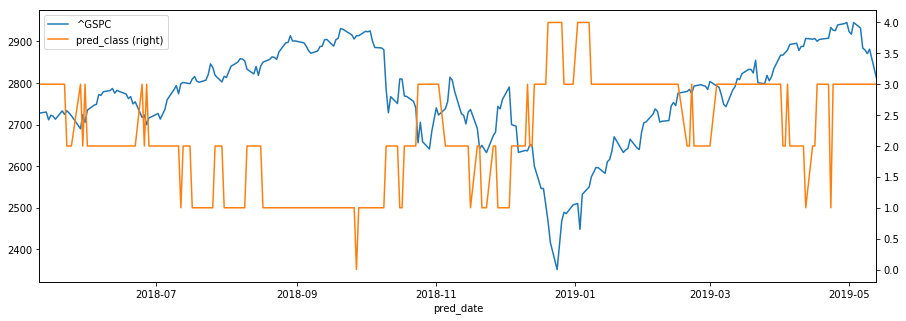

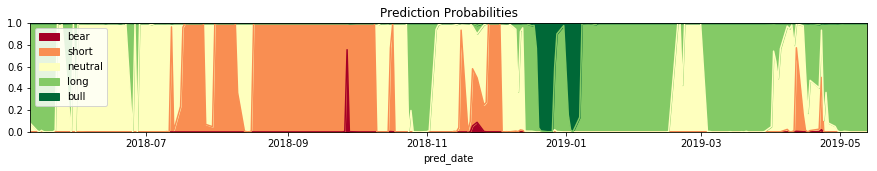

In [112]:
pre_class_cols = filter_cols(pred_df.columns, "pred_class")
pred_df.loc[:,[bench] + pre_class_cols].plot(
    secondary_y=pre_class_cols, figsize=(15, 5));
pred_df[fwd_ret_labels].plot.area(
        title='Prediction Probabilities',
        figsize=(15, 2), ylim=(0, 1), cmap='RdYlGn');
f'Confidence Mean: {pred_df["confidence"].mean().round(3)}, Median {pred_df["confidence"].median().round(3)}'

### Step by step

#### Dataset creation

In [ ]:
# average the return of the next periods
# select only rows where Y variable is not null
train_idx = px_close.dropna(subset=[bench]).index
Y = px_fwd_rets(px_close.loc[train_idx, bench], bench, pred_fwd_windows).mean(axis=1)
Y.plot.hist(bins=50, title='Distribution of Forwards Returns')
Y.shape

In [ ]:
%%time
df_large = pd.DataFrame()

# rate transforms
rate_ft_df = rate_feats(px_close[rateSL], rate_windows)
df_large[rate_ft_df.columns] = rate_ft_df

# price momentum transforms
super_list = []
for ticker in include:
    inv = ticker in invert
    incl_px = True if ticker in incl_price else False
    df = px_close[ticker]
    ft_df = px_mom_feats(df, ticker, stds, inv, incl_px, sec_windows)
    super_list.append(ft_df.drop_duplicates())
df_large = pd.concat(super_list, axis=1).sort_index()

df_large[y_col] = Y

# drop NAs before discretizing
df_large = df_large.loc[train_idx, :]

print(df_large.shape)

In [ ]:
os.makedirs('tmp', exist_ok=True)
df_large.to_parquet('tmp/macro-ds-large')

#### Pre-processing

In [ ]:
df_large = pd.read_parquet('tmp/macro-ds-large')
df_large.shape

In [ ]:
# Trims dataset in case it's too large for experimentation
# Reduce dataset for experimentation
# Note that experiment dataset is not stratified
_, df_raw = train_test_split(df_large, test_size=100e-2, shuffle=False, )
df_raw.shape

In [ ]:
# keeps a chunk of the pre-processed dataset for predictions later
# take everything but Y var
look_back = 252*3
recent_X = df_large.iloc[-look_back:,:-1].copy()
print(recent_X.shape)

In [ ]:
# discretize returns into classes
df_raw.dropna(subset=[y_col], inplace=True)
df_raw.loc[:, y_col] = discret_rets(df_raw[y_col], cut_range, fwd_ret_labels)

y_col_dist = sample_wgts(df_raw[y_col], fwd_ret_labels)
(y_col_dist[fwd_ret_labels]).round(3)

In [ ]:
# how many empty values?
# (df_raw.isna().sum() / df_raw.count()).sort_values(ascending=False)

In [ ]:
df_raw.fillna(method='ffill', inplace=True)

In [ ]:
# Mean based imputer
imputer_on, scaler_on = True, True
imputer = SimpleImputer(missing_values=np.nan, strategy='median', copy=False)
scaler = StandardScaler()

df_raw.replace([np.inf, -np.inf], np.nan, inplace=True)

pre_ml_df = df_raw.copy()
pre_ml_df.dropna(subset=[y_col], inplace=True)
pre_ml_df.loc[:, y_col] = pre_ml_df[y_col].astype(str)

X_cols = excl(pre_ml_df.columns, [y_col])

if imputer_on: pre_ml_df.loc[:, X_cols] = imputer.fit_transform(pre_ml_df[X_cols])
else: pre_ml_df.dropna(inplace=True)
if scaler_on: pre_ml_df.loc[:, X_cols] = scaler.fit_transform(pre_ml_df[X_cols])

X, y = pre_ml_df.drop(columns=y_col), pre_ml_df[y_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

#### Train models

In [ ]:
# RandomForestClassifier
# best params from GridSearch
rfc_params = {
    'max_features': 40, 'n_estimators': 100, 'random_state': 7}

clf1 = RandomForestClassifier(**rfc_params, warm_start=True)

clf1.fit(X_train, y_train)
scores = clf1.score(X_train, y_train), clf1.score(X_test, y_test)
scores

In [ ]:
# MLPClassifier
# best params from GridSearch
mlp_params = {
    'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 65, 
    'learning_rate': 'adaptive', 'max_iter': 200, 
    'random_state': 3, 'solver': 'lbfgs'}

clf2 = MLPClassifier(**mlp_params, warm_start=True)

clf2.fit(X_train, y_train)
scores = clf2.score(X_train, y_train), clf2.score(X_test, y_test)
scores

In [ ]:
# ExtraTreesClassifier
clf3 = ExtraTreesClassifier(
    n_estimators=100, max_depth=None, 
    min_samples_split=2, random_state=0, warm_start=True)

clf3.fit(X_train, y_train)
scores = clf3.score(X_train, y_train), clf3.score(X_test, y_test)
scores

In [ ]:
%%time

eclf = VotingClassifier(
    estimators=[('rf', clf1), ('mlp', clf2), ('et', clf3)], 
    voting=vote)

clf = eclf.fit(X_train, y_train)
scores = clf.score(X_train, y_train), clf.score(X_test, y_test)

print(scores)

In [ ]:
os.makedirs(ml_path, exist_ok=True)
fname = ml_path + f'macro_ML_{vote}.pkl'
joblib.dump(clf, fname)
f'Saved {fname}'    

In [ ]:
clf = joblib.load(fname)
print('Loaded', fname)

In [ ]:
# predict historically including recent dates
if imputer_on: recent_X.loc[:, X_cols] = imputer.fit_transform(recent_X[X_cols])
else: recent_X.dropna(inplace=True)
if scaler_on: recent_X.loc[:, X_cols] = scaler.fit_transform(recent_X[X_cols])

In [ ]:
assert recent_X.shape[1] == X_train.shape[1]

In [ ]:
assert recent_X.shape[1] == X_train.shape[1]
preds = clf.predict(recent_X)
assert recent_X.shape[0] == preds.shape[0]

pred_class = np.array([fwd_ret_labels.index(x) for x in preds])

SPY = px_close.loc[recent_X.index, bench].to_frame()
SPY['pred_class'] = pred_class
SPY['pred_label'] = preds

if vote == 'soft':
    probs = clf.predict_proba(recent_X)
    pred_prob = np.argmax(probs, axis=1)
    SPY.loc[:, 'high_prob'] = [x[np.argmax(x)] for x in probs] # higest prob
    SPY.loc[:, 'pred_prob'] = probs[range(pred_class.shape[0]), pred_class] # predict class prob

SPY.dropna(subset=[bench], inplace=True)    

In [ ]:
# why are predict classes and prob distribution do not math?
# preds, pred_class, probs[-10:]
# df = pd.DataFrame()
# df['pred_class'] = pred_class
# df['pred_prob'] = probs[range(pred_class.shape[0]), pred_class]
# df.plot(secondary_y='pred_prob')

In [ ]:
# plot predictions
SPY['pred_class'] = pred_class
SPY['pred_label'] = preds
SPY.loc[:,[bench, 'pred_class']].plot(secondary_y='pred_class', figsize=(15, 5));

if vote == 'soft':
    SPY[['high_prob']].plot(
        title='Historical predictions',
        figsize=(15, 2), ylim=(0, 1),);
    SPY[['pred_prob']].plot(
        title='Probability of highest & predicted class',
        figsize=(15, 2), ylim=(0, 1),);
    
    prob_df = pd.DataFrame(probs, columns=fwd_ret_labels, index=recent_X.index)
    prob_df.plot(
        title='Class probabilities',
        figsize=(15, 8), subplots=True, ylim=(0,1));    

In [ ]:
if vote == 'soft':
    SPY[['high_prob', 'pred_prob']].plot.hist(
        bins=50, xlim=(0,1), title='Confidence Distribution')
    print('Probability for predicted class: Mean %.f, median %.f, ' % (
        SPY.pred_prob.mean() * 100,
        SPY.pred_prob.median() * 100))
    print('Probability for highest class: Mean %.f, median %.f, ' % (
        SPY.high_prob.mean() * 100,
        SPY.high_prob.median() * 100))

In [ ]:
SPY.tail(10)

#### Metrics

In [ ]:
draw_tree(clf1.estimators_[0], X, precision=3)

In [ ]:
show_fi(clf1, X, 25)

In [ ]:
log_loss(y_test, clf1.predict_proba(X_test))

In [ ]:
print('Confussion Matrix\n', confusion_matrix(clf.predict(X_test), y_test, labels=fwd_ret_labels))

In [ ]:
print('Classificaton report\n', classification_report(clf.predict(X_test), y_test, target_names=fwd_ret_labels))

In [ ]:
fi = rf_feat_importance(clf1, pd.DataFrame(X)); fi[:10]

In [ ]:
clf1.predict_proba(X_test)

In [ ]:
[plt.plot(x.tolist(), alpha=0.1, color='b', marker='*', linewidth=0) for x in clf1.predict_proba(X_test)];

#### Gridsearches

In [ ]:
%%time
# GridSearchCV for RandomForestClassifier
verbose = True
parameters = {
    'n_estimators': [100],
    'max_features': ['sqrt'],
    'random_state': np.arange(0, 5, 1),}
clf = GridSearchCV(RandomForestClassifier(), 
                   parameters, n_jobs=-1, 
                   cv=5, iid=True, verbose=5)
clf.fit(X_train, y_train)
if verbose: print_cv_results(
    clf, X_train, X_test, y_train, y_test, 
    feat_imp=True, top=20)

In [ ]:
%%time
# GridSearchCV for MLPClassifier
parameters = {
    'solver': ['lbfgs'], # ['lbfgs', 'sgd', 'adam']
    'max_iter': [200], # [200, 400, 600]
    'activation': ['relu'], # ['logistic', 'tanh', 'relu']
    'alpha': 10.0 ** -np.arange(2, 5, 1), # 10.0 ** -np.arange(2, 5, 1)
    'learning_rate' : ['adaptive'], # ['constant', 'adaptive']
    'hidden_layer_sizes': np.arange(5, X_train.shape[1] // 3, int(X_train.shape[1] * 0.1)), # np.arange(5, 50, 10)
    'random_state': np.arange(0, 5, 1)} # np.arange(0, 10, 2)
clf = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1, cv=5,
                  iid=True, verbose=5)
clf.fit(X_train, y_train)
if verbose: print_grid_search(
    clf, X_train, y_train, X_test, y_test, 
    feat_imp=False, top=20)

### Old

#### Feature construction

In [ ]:
# FX
FX = ['EURUSD=X', 'JPY=X', 'GBPUSD=X', 'CNY=X', 'CHF=X', 'DX-Y.NYB']
invert = ['EURUSD=X', 'GBPUSD=X']
df_raw = px_close[FX]
df_raw.describe().T

In [ ]:
fx_df = df_raw.copy()
fx_df[invert] = (1 / df_raw[invert])
fx_df.tail(252)
fx_chg_df = fx_df.pct_change().rolling(60).sum()
fx_chg_df.plot.kde()

In [ ]:
rates = px_close[rateSL]
rates.plot.kde(alpha=1, title='Yield Curve Rate Distribution')
rate_feats(rates, [60]).plot.kde(title='10Yr - 3M Spread')

In [ ]:
%%time
# Uses px_mom_feats for FX transforms
FX = ['EURUSD=X', 'JPY=X', 'GBPUSD=X', 'CNY=X', 'CHF=X', 'DX-Y.NYB']
invert = ['EURUSD=X', 'GBPUSD=X']

ndf = pd.DataFrame() 
for fx in FX:
    inv = True if fx in invert else False
    df = get_symbol_pricing(fx)
    ft_df = px_mom_feats(df, fx, 1, inv, True)
    ndf[ft_df.columns] = ft_df
ndf.plot.hist(alpha=0.5, legend=False)

In [ ]:
ft_df = px_mom_feats(get_symbol_pricing('^VIX'), '^VIX', 2, False, True, [20])
print(ft_df.columns)
ft_df.iloc[:,:].plot.hist()

In [ ]:
symbol = '^GSPC'
px_df = get_symbol_pricing(symbol)

ft_df = px_mom_feats(px_df, symbol)
# ft_df.plot(subplots=True, figsize=(10,15));
ft_df.plot.hist(alpha=0.5);

In [ ]:
ft_df = px_fwd_rets(px_df, symbol)
ft_df.plot.hist(alpha=0.5);
ft_df[symbol] = px_df['close']
ft_df.tail(252*4).plot(secondary_y=symbol, figsize=(10,5));

In [ ]:
%%time
# average different time frames of fwd rets for all benchmarks
# do we try to estimate the average of all benchmarks or just one?
# do we try to estimate three type of fwd rets [20, 60, 120] or just one?

# calculate forward returns for all bechmarks
fwd_rets_df = pd.DataFrame()
for s in benchSL:
    px_df = get_symbol_pricing(s)
    fwd_ret = px_fwd_rets(px_df, s)
    fwd_rets_df[fwd_ret.columns] = fwd_ret
fwd_rets_df.tail()

[fwd_rets_df[[x for x in fwd_rets_df.columns if y in x]].mean(axis=1).plot.hist(alpha=0.5)
     for y in ['g20', 'g60', 'g120']]

#### Visualizations

In [ ]:
locs = [-int(x**3) for x in range(1, 7, 1)]
px_close[rateSL].iloc[locs, :].T.plot(title='Historical Yield Curve');
#f'Yield curve for the last {locs} days'

In [ ]:
# show correlations with Y variables
show = ['mktFwdChg1m', 'mktFwdChg3m', 'mktFwdChg6m']
ml_ds_df.corr()[show]

In [ ]:
# series distributions
%time ml_ds_df.hist(figsize=(15,15));

In [ ]:
# scatter plots
%time pd.plotting.scatter_matrix(ml_ds_df, alpha=0.1, figsize=(40, 40));

In [ ]:
# historical returns for 1, 3, and 6 months
secpx['mktHistPctChgStds'] = SPY_pct_chg.apply(sign_compare, args=(SPY_pct_chg.std(),))
secpx['mktHistPctChg1m'] = SPY_close.pct_change(periods=20)
secpx['mktHistPctChg3m'] = SPY_close.pct_change(periods=60)
secpx['mktHistPctChg6m'] = SPY_close.pct_change(periods=120)
secpx['mktPerc52WkHigh'] = (SPY_close / SPY_close.rolling(252).max())
secpx['mktPerc52WkLow'] = (SPY_close / SPY_close.rolling(252).min())

show = ['mktHistPctChgStds', 'mktHistPctChg1m', 'mktHistPctChg3m', 
        'mktHistPctChg6m']
secpx[show].hist();
secpx[show].tail(252*4).plot(secondary_y='mktHistPctChgStds');
show = ['mktPerc52WkLow']
secpx[show].tail(252*4).plot();

In [ ]:
# Forward returns, 1w, 1m, 3m
SPY_close.pct_change(5).shift(-5)
secpx['mktFwdChg1m'] = SPY_close.pct_change(20).shift(-20)
secpx['mktFwdChg3m'] = SPY_close.pct_change(60).shift(-60)
secpx['mktFwdChg6m'] = SPY_close.pct_change(120).shift(-120)

show = ['mktFwdChg1m', 'mktFwdChg3m', 'mktFwdChg6m']
secpx[show].hist();
secpx[show].tail(252*4).plot();

In [ ]:
show = [bench_symbol, 'mktFwdChg1m', 'mktFwdChg3m', 'mktFwdChg6m']
secpx[show].tail(252*4).plot(secondary_y=bench_symbol, figsize=(12,5));

In [ ]:
# cumulative deltas and gap analysis
secpx['pctChgStds'] = pct_chg.apply(sign_compare, args=(pct_chg.std(),))
secpx['openGap1m'] = (openpx - closepx.shift(1)).rolling(20).sum()
secpx['hlDelta1m'] = (highpx - lowpx).rolling(20).sum()
secpx['cumChg1m'] = (closepx - closepx.shift(1)).rolling(20).sum()
secpx['cumChg3m'] = (closepx - closepx.shift(1)).rolling(60).sum()
secpx['cumChg6m'] = (closepx - closepx.shift(1)).rolling(120).sum()
secpx['perc52WkLow'] = (closepx / closepx.rolling(252).min())

show = ['pctChgStds', 'openGap1m', 'hlDelta1m', 
        'cumChg1m', 'cumChg3m', 'cumChg6m']
secpx[show].hist();
secpx[show].tail(252*4).plot(secondary_y='pctChgStds');
show = ['perc52WkLow']
secpx[show].tail(252*4).plot();

In [ ]:
show = ['pctChgStds', 'mktHistPctChgStds']
secpx[show].hist();
secpx[show].tail(252*4).plot();

In [ ]:
# rolling SPY correlations
secpx['crossCorr1m'] = closepx.pct_change().rolling(20).corr(SPY_pct_chg)
secpx['crossCorr3m'] = closepx.pct_change().rolling(60).corr(SPY_pct_chg)

show = [bench_symbol, 'crossCorr1m', 'crossCorr3m']
secpx[show].tail(252*4).plot(secondary_y=bench_symbol);
# closepx.pct_change().corr(SPY_pct_chg)

#### Missing values

In [ ]:
# px_close.loc[pred_X.index, keep_bench].tail(20)
# pred_X.tail()

In [ ]:
# pred_X.fillna(method='ffill', inplace=True)
# na = pred_X.tail(120).isna().any(0)
# pred_X[na[na.values].index]

#### Fixing timeseries concatenation

In [ ]:
super_list = []
for n, t in enumerate(keep_sect):
    try:
        df = get_symbol_pricing(t, freq, cols=None)
        rename_col(df, 'close', t)
        print("Retrieving pricing: {0}, {1}".format(t, df.shape))
        df.index = df.index.strftime('%Y-%m-%d')
        super_list.append(df[t])
    except Exception as e:
        print("Exception, get_mults_pricing: {0}\n{1}".format(t, e))

In [ ]:
full_df = pd.DataFrame(super_list[0])
if len(super_list[1:]):
    for x in super_list[1:]: full_df = pd.merge(full_df, x, left_index=True, right_index=True, how='outer')
full_df.index = pd.to_datetime(full_df.index)

In [ ]:
full_df.tail(20)

In [ ]:
super_list[0].tail(10)

In [ ]:
super_list[1].tail(10)

In [ ]:
super_list[2].tail(10)

In [ ]:
get_symbol_pricing('JPY=X')

In [ ]:
full_df.tail(30).sort_index()

In [ ]:
for d in super_list:
    print(d.shape, d.drop_duplicates().shape)

In [ ]:
super_list[1].duplicated().sort_values()

In [ ]:
df = pd.concat(super_list, axis=1)

In [ ]:
super_list[0].tail(10).index, \
super_list[1].tail(10).index, \
super_list[2].tail(10).index, \
super_list[3].tail(10).index

In [ ]:
ss = get_symbol_pricing('DX-Y.NYB', freq).tail(20)

In [ ]:
ss.index.strftime('%Y-%m-%d')

In [ ]:
# pd.merge(super_list[1], super_list[2], left_index=True, right_index=True)
# pd.concat(super_list, axis=1)
init_df = pd.DataFrame(super_list[0])
for x in super_list[1:]:
    init_df = pd.merge(init_df, x, left_index=True, right_index=True)
init_df.tail(60)

In [ ]:
pd.concat(super_list, axis=1, ).tail(15)

In [ ]:
for d in super_list: d.drop_duplicates(inplace=True)

In [ ]:
df = pd.concat(super_list, axis=1, copy=False)